In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, IterableDataset

import numpy as np
# import matplotlib.pyplot as plt
import pandas as pd

import time
import os
import copy
import json
import random

from PIL import Image

# from transformers import BertTokenizer, BertModel
import pickle

from sklearn.decomposition import PCA
# from cca_zoo.models import CCA
from sklearn.preprocessing import normalize

# making sure that the whole embedding tensor is printed in output
torch.set_printoptions(threshold=10_000)

# Loading necessary files

In [10]:
img_val = torch.load("img_val.pt")
text_val = torch.load("text_val.pt")

img_train = torch.load("img_train.pt")
text_train = torch.load("text_train.pt")

img_test = torch.load("img_test.pt")
text_test = torch.load("text_test.pt")

ingredients_test = torch.load("test_ingredients.pt")
instructions_test = torch.load("test_instructions.pt")
title_test = torch.load("test_title.pt")

ingredients_train = torch.load("train_ingredients.pt")
instructions_train = torch.load("train_instructions.pt")
title_train = torch.load("train_title.pt")

# STEP 1

## Visualization on Best Model: dims = 500

In [7]:
test_embeddings = []
with open('embeddings_test1.pkl', 'rb') as f:
    try:
        while True:
            test_embeddings.append(pickle.load(f))
    except:
        pass

In [8]:
test_files = test_embeddings[0][2]

In [55]:
train_embeddings = []
with open('embeddings_train1.pkl', 'rb') as f:
    try:
        while True:
            train_embeddings.append(pickle.load(f))
    except:
        pass

In [58]:
train_files = train_embeddings[0][2]

Showing the image and text representations learn the same thing

In [9]:
print("Applying CCA")
cca = CCA(latent_dims = 500, random_state = 0)
cca.fit((img_train, text_train))
print("CCA done")
print("Transforming")
img_train_r, text_train_r = cca.transform((img_train, text_train))
img_test_r, text_test_r = cca.transform((img_test, text_test))

Applying CCA
CCA done
Transforming


In [16]:
from sklearn.manifold import TSNE
img_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state = 0).fit_transform(img_test_nonlinear[:10000])
text_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state = 0).fit_transform(text_test_nonlinear[:10000])

<AxesSubplot:>

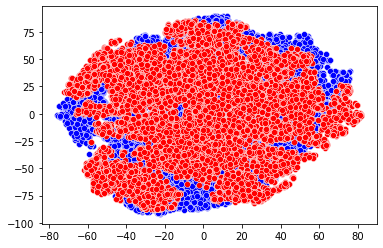

In [17]:
import seaborn as sns
sns.scatterplot(x = img_embedded[:,0], y = img_embedded[:,1], color = 'b')
sns.scatterplot(x = text_embedded[:,0],y = text_embedded[:,1], color = 'r')

In [32]:
text_embedded2 = TSNE(n_components=2, learning_rate='auto', init='random', random_state = 0).fit_transform(text_test_r[:10])
img_embedded2 = TSNE(n_components=2, learning_rate='auto', init='random', random_state = 0).fit_transform(img_test_r[:10])

Text(0.5, 1.0, 'First 2 t-SNE components of \n latent text representation')

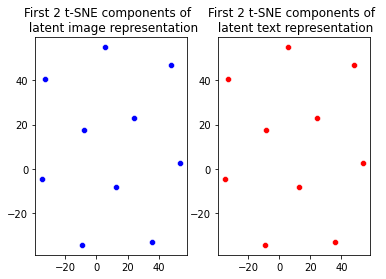

In [96]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(ax = ax[0], x = img_embedded2[:,0], y = img_embedded2[:,1], color = 'b')
sns.scatterplot(ax = ax[1], x = text_embedded2[:,0],y = text_embedded2[:,1], color = 'r')
ax[0].set_title("First 2 t-SNE components of  \n latent image representation")
ax[1].set_title("First 2 t-SNE components of \n latent text representation")

Showing the image and text representations can differentiate between recipes

In [108]:
with open("muffin_ids.txt") as f:
    muffin_ids = f.readlines()

muffin_ids = [muffin_id.rstrip() for muffin_id in muffin_ids]

In [110]:
with open("salad_ids.txt") as f:
    salad_ids = f.readlines()

salad_ids = [salad_id.rstrip() for salad_id in salad_ids]

In [156]:
muffin_img_emb = []
muffin_txt_emb = []
salad_img_emb = []
salad_txt_emb = []

In [169]:
muffin_idxs = []
salad_idxs = []

for i in muffin_ids:
    muffin_idxs = np.where(train_files == i)

for i in salad_ids:
    salad_idxs = np.where(train_files == i)

<ipython-input-169-e02e0f73ae86>:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  salad_idxs = np.where(train_files == i)


In [170]:
for i in muffin_idxs:
    muffin_img_emb.append(img_train_r[i])
    muffin_txt_emb.append(text_train_r[i])
    
for i in salad_idxs:
    salad_img_emb.append(img_train_r[i])
    salad_txt_emb.append(text_train_r[i])

In [175]:
salad_img_emb = salad_img_emb[:100]
salad_txt_emb = salad_txt_emb[:100]

In [ ]:
muffin_txt_embedded = TSNE(n_components=2, perplexity = 150, learning_rate='auto', init='random', random_state = 0).fit_transform(np.array(muffin_txt_emb).reshape(-1,1)[:100])
muffin_img_embedded = TSNE(n_components=2,  perplexity = 150, learning_rate='auto', init='random', random_state = 0).fit_transform(np.array(muffin_img_emb).reshape(-1,1)[:100])
salad_txt_embedded2 = TSNE(n_components=2,  perplexity = 150, learning_rate='auto', init='random', random_state = 0).fit_transform(np.array(salad_txt_emb).reshape(-1,1))
salad_img_embedded2 = TSNE(n_components=2,  perplexity = 150, learning_rate='auto', init='random', random_state = 0).fit_transform(np.array(salad_img_emb).reshape(-1,1))

Text(0.5, 1.0, 'First 2 t-SNE components of \n latent image representation')

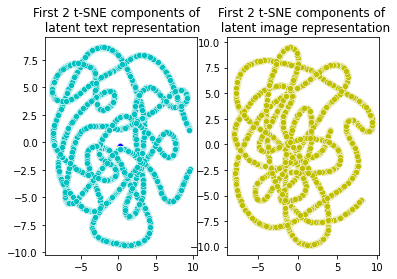

In [187]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(ax = ax[0], x = muffin_txt_embedded[:,0], y = muffin_txt_embedded[:,1], color = 'b')
sns.scatterplot(ax = ax[0], x = salad_txt_embedded[:,0], y = salad_txt_embedded[:,1], color = 'c')
sns.scatterplot(ax = ax[1], x = muffin_img_embedded[:,0],y = muffin_img_embedded[:,1], color = 'r')
sns.scatterplot(ax = ax[1], x = salad_img_embedded[:,0],y = salad_img_embedded[:,1], color = 'y')

ax[0].set_title("First 2 t-SNE components of  \n latent text representation")
ax[1].set_title("First 2 t-SNE components of \n latent image representation")

# STEP 2

In [8]:
!export CUDA_VISIBLE_DEVICES='0,1'

In [4]:
import pickle
import os
import torch
import json
import pandas as pd
import numpy as np
from tqdm import tqdm

## tSNE embeddings on test data - MSE / 512

In [7]:
device = torch.device("cuda:0")

In [8]:
class EmbeddingNetwork(nn.Module):
    def __init__(self, output_size, input_size=1024):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(),
            nn.LeakyReLU()
        )
        self.layer2 = nn.Linear(512, output_size)

    def forward(self, x):
        x = self.layer1(x)
        return self.layer2(x)

In [15]:
img_model = EmbeddingNetwork(512)
img_model = nn.DataParallel(img_model, device_ids=[0,1])
img_model.load_state_dict(torch.load("checkpoints/img-model-full-512-tl-epoch-20.pth"))
img_model.to(device);
img_model.eval();
txt_model= EmbeddingNetwork(512)
txt_model = nn.DataParallel(txt_model, device_ids=[0,1])
txt_model.load_state_dict(torch.load("checkpoints/txt-model-full-512-tl-epoch-20.pth"))
txt_model.to(device);
txt_model.eval();

img_test_nonlinear = np.zeros(shape = (len(img_test), 512))
text_test_nonlinear = np.zeros(shape = (len(img_test), 512))

for i in range(len(img_test)):
    img_test_nonlinear[i] = img_model(torch.Tensor(np.expand_dims(img_test[i], 0))).cpu().detach().numpy()
    text_test_nonlinear[i] = txt_model(torch.Tensor(np.expand_dims(text_test[i], 0))).cpu().detach().numpy()

In [13]:
from sklearn.manifold import TSNE
img_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state = 0).fit_transform(img_test_nonlinear[:10000])
text_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state = 0).fit_transform(text_test_nonlinear[:10000])

<AxesSubplot:>

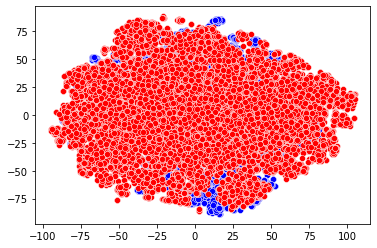

In [14]:
import seaborn as sns
sns.scatterplot(x = img_embedded[:,0], y = img_embedded[:,1], color = 'b')
sns.scatterplot(x = text_embedded[:,0],y = text_embedded[:,1], color = 'r')

## tSNE embeddings on test data - Triplet Loss / 512

In [15]:
img_model = EmbeddingNetwork(512)
img_model = nn.DataParallel(img_model, device_ids=[0,1])
img_model.load_state_dict(torch.load("checkpoints/img-model-full-512-tl-epoch-20.pth"))
img_model.to(device);
img_model.eval();
txt_model= EmbeddingNetwork(512)
txt_model = nn.DataParallel(txt_model, device_ids=[0,1])
txt_model.load_state_dict(torch.load("checkpoints/txt-model-full-512-tl-epoch-20.pth"))
txt_model.to(device);
txt_model.eval();

img_test_nonlinear = np.zeros(shape = (len(img_test), 512))
text_test_nonlinear = np.zeros(shape = (len(img_test), 512))

for i in range(len(img_test)):
    img_test_nonlinear[i] = img_model(torch.Tensor(np.expand_dims(img_test[i], 0))).cpu().detach().numpy()
    text_test_nonlinear[i] = txt_model(torch.Tensor(np.expand_dims(text_test[i], 0))).cpu().detach().numpy()

In [16]:
from sklearn.manifold import TSNE
img_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state = 0).fit_transform(img_test_nonlinear[:10000])
text_embedded = TSNE(n_components=2, learning_rate='auto', init='random', random_state = 0).fit_transform(text_test_nonlinear[:10000])

<AxesSubplot:>

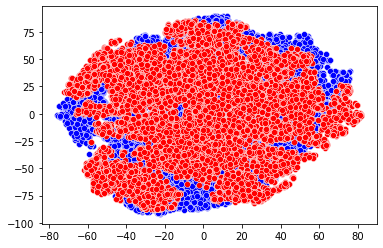

In [17]:
import seaborn as sns
sns.scatterplot(x = img_embedded[:,0], y = img_embedded[:,1], color = 'b')
sns.scatterplot(x = text_embedded[:,0],y = text_embedded[:,1], color = 'r')

## Embeddings Arithmetic 

In [2]:
## using the train embeddings given
f = open('embeddings_train1.pkl', 'rb')
d_train = pickle.load(f)
df_train = pd.DataFrame({'id':d_train[2]})
df_train.reset_index(inplace=True)
df_train = df_train.set_index('id')

## using the test embeddings given
f = open('embeddings_test1.pkl', 'rb')
d_test = pickle.load(f)
df_test = pd.DataFrame({'id':d_test[2]})
df_test.reset_index(inplace=True)
df_test = df_test.set_index('id')

train_text_features, train_img_features, test_text_features, test_img_features = torch.tensor(d_train[1]), torch.tensor(d_train[0]), torch.tensor(d_test[1]), \
torch.tensor(d_test[0])

In [3]:
f = open('layer2.json', 'rb')
image_mapping = json.load(f)

data_map_list = []
for row in image_mapping:
    for image in row['images']:
        data_map_list.append([row['id'], image['id']])
        break
    
data_map_df = pd.DataFrame(data_map_list, columns=['id', 'image_id'])
data_map_df['id'] = data_map_df['id'].astype(str)
data_map_df.reset_index(inplace=True)
data_map_df.drop(columns=['index'], inplace=True)
data_map_df = data_map_df.set_index('id')

In [4]:
f = open('layer1.json', 'rb')
title_mapping = json.load(f)
text_data_list = []

for row in title_mapping:
    text_data_list.append([row['id'], row['title']])
    
text_map_df = pd.DataFrame(text_data_list, columns=['id', 'title'])
text_map_df['id'] = text_map_df['id'].astype(str)
text_map_df.reset_index(inplace=True)
text_map_df = text_map_df.set_index('id')

In [5]:
train_data_map_df = df_train.join(data_map_df).join(text_map_df, lsuffix='_left', rsuffix='_right')
train_data_map_df['title'] = train_data_map_df['title'].str.lower()

test_data_map_df = df_test.join(data_map_df).join(text_map_df, lsuffix='_left', rsuffix='_right')
test_data_map_df['title'] = test_data_map_df['title'].str.lower()

### MSE Loss / dims = 512

In [28]:
img_model = EmbeddingNetwork(512)
img_model = nn.DataParallel(img_model, device_ids=[0,1])
img_model.load_state_dict(torch.load("checkpoints/img-model-full-512-tl-epoch-20.pth"))
img_model.to(device);
img_model.eval();
txt_model= EmbeddingNetwork(512)
txt_model = nn.DataParallel(txt_model, device_ids=[0,1])
txt_model.load_state_dict(torch.load("checkpoints/txt-model-full-512-tl-epoch-20.pth"))
txt_model.to(device);
txt_model.eval();

img_test_nonlinear = np.zeros(shape = (len(img_test), 512))
text_test_nonlinear = np.zeros(shape = (len(img_test), 512))

for i in range(len(img_test)):
    img_test_nonlinear[i] = img_model(torch.Tensor(np.expand_dims(img_test[i], 0))).cpu().detach().numpy()
    text_test_nonlinear[i] = txt_model(torch.Tensor(np.expand_dims(text_test[i], 0))).cpu().detach().numpy()

In [29]:
img_train_nonlinear = np.zeros(shape = (len(img_train), 512))
text_train_nonlinear = np.zeros(shape = (len(img_train), 512))

for i in range(len(img_train)):
    img_train_nonlinear[i] = img_model(torch.Tensor(np.expand_dims(train_img_features[i], 0))).cpu().detach().numpy()
    text_train_nonlinear[i] = txt_model(torch.Tensor(np.expand_dims(train_text_features[i], 0))).cpu().detach().numpy()

In [30]:
trans_train_text_features, trans_train_img_features = text_train_nonlinear, img_train_nonlinear
trans_test_text_features, trans_test_img_features = text_test_nonlinear, img_test_nonlinear

In [31]:
full_data = []

#finding the mean cake and cup-cake vector
all_cake = train_data_map_df[train_data_map_df['title'].str.contains('cake') & train_data_map_df['title'].str.contains('chocolate')]
just_cake = train_data_map_df[train_data_map_df['title'].str.contains('cake')]
cup_cake = train_data_map_df[train_data_map_df['title'].str.contains('cupcake') ]

cake_mean = np.mean(trans_train_text_features[just_cake['index_left']], axis=0)
cup_cake_mean = np.mean(trans_train_text_features[cup_cake['index_left']], axis=0)

In [43]:
test_data_map_df[test_data_map_df['title'].str.contains('chocolate cake')]

,index_left,image_id,index_right,title
id,,,,
00421bfcd3,57,0a4f613412.jpg,1034,the ultimate chocolate cake
00e530bf61,187,3ae2fd8286.jpg,3640,wacky chocolate cake pops
032752603d,683,5b55b733a6.jpg,12787,guinness chocolate cake
039de26a91,813,e046fc6d5d.jpg,14639,boca negra (bourbon chocolate cake)
0473ac7792,1004,2d8a8f58e5.jpg,18022,very good chocolate cake
...,...,...,...,...
f508a30fda,58195,abdf3ffc9a.jpg,985904,molten chocolate cake with marshmallow filling
f918d64db0,59187,037f1f2130.jpg,1002404,banana - chocolate cake
f9c88a5905,59333,253a71d4dd.jpg,1005120,m&m chocolate cake!


In [44]:
# doing the arithmetic operation for chocolate cake - cake + cupcake = chocolate cupcake
data = {}

_id = "00421bfcd3"
data['test_image'] = {'id' : _id, 'title': test_data_map_df[test_data_map_df.index == _id]['title'].values[0], 'image_id': test_data_map_df[test_data_map_df.index == _id]['image_id'].values[0]}

chocolate_cake = test_img_features[test_data_map_df[test_data_map_df.index == _id]['index_left']]
chocolate_cake_mean = np.mean(trans_train_img_features[np.dot(chocolate_cake, train_img_features.T).argsort().reshape(-1, )[-4:]], axis=0)
nn4_df = train_data_map_df.iloc[np.dot(chocolate_cake, train_img_features.T).argsort().reshape(-1, )[-4:]]

cake_mean_nn4_df = train_data_map_df.iloc[np.dot(cake_mean, trans_train_img_features.T).argsort().reshape(-1, )[-4:]]
cup_cake_mean_nn4_df = train_data_map_df.iloc[np.dot(cup_cake_mean, trans_train_img_features.T).argsort().reshape(-1, )[-4:]]

data['ids_closest_to_query'] = []
for i,j in zip(nn4_df['title'], nn4_df['image_id']):
    data['ids_closest_to_query'].append([i, j])

data['ids_closest_to_second'] = []
for i,j in zip(cake_mean_nn4_df['title'], cake_mean_nn4_df['image_id']):
    data['ids_closest_to_second'].append([i, j])

data['ids_closest_to_third'] = []
for i,j in zip(cup_cake_mean_nn4_df['title'], cup_cake_mean_nn4_df['image_id']):
    data['ids_closest_to_third'].append([i, j])


chocolate_cup_cake = chocolate_cake_mean.reshape(1, -1) - 1 * cake_mean.reshape(1, -1) + 1 * cup_cake_mean.reshape(1, -1)
retrieved_df = train_data_map_df.iloc[np.argmax(np.dot(chocolate_cup_cake, trans_train_img_features.T))]
data['returned_id'] = {'title': retrieved_df['title'], 'image_id': retrieved_df['image_id']}
full_data.append(data)

full_data

[{'test_image': {'id': '00421bfcd3',
   'title': 'the ultimate chocolate cake',
   'image_id': '0a4f613412.jpg'},
  'closest': [['chocolate truffle cake', '82bcd0e182.jpg'],
   ['chocolate chocolate-chip cake', 'f795cd0b6c.jpg'],
   ['double chocolate zucchini cake', '8676d9bd9e.jpg'],
   ['one bowl dark chocolate cake', '1154e768a3.jpg']],
  'closet_minus': [['lemon bars', 'aa0459669a.jpg'],
   ['christmas sprouts!', '0b5c4fdb80.jpg'],
   ['fudgy raspberry brownies', '68a1c63bc6.jpg'],
   ['big batch fudgy brownies', '2a22436e7f.jpg']],
  'closet_plus': [['holiday holly chocolate cupcakes', 'b02a4f1cb6.jpg'],
   ['fudgy raspberry brownies', '68a1c63bc6.jpg'],
   ['nutella cheesecake pumpkin muffins', 'c2ce84f28d.jpg'],
   ['big batch fudgy brownies', '2a22436e7f.jpg']],
  'retr': {'title': 'bay head cream cheese spread',
   'image_id': '5d4a9eb94d.jpg'}}]

### Triplet loss / dims = 512

In [28]:
img_model = EmbeddingNetwork(512)
img_model = nn.DataParallel(img_model, device_ids=[0,1])
img_model.load_state_dict(torch.load("checkpoints/img-model-full-512-tl-epoch-20.pth"))
img_model.to(device);
img_model.eval();
txt_model= EmbeddingNetwork(512)
txt_model = nn.DataParallel(txt_model, device_ids=[0,1])
txt_model.load_state_dict(torch.load("checkpoints/txt-model-full-512-tl-epoch-20.pth"))
txt_model.to(device);
txt_model.eval();

img_test_nonlinear = np.zeros(shape = (len(img_test), 512))
text_test_nonlinear = np.zeros(shape = (len(img_test), 512))

for i in range(len(img_test)):
    img_test_nonlinear[i] = img_model(torch.Tensor(np.expand_dims(img_test[i], 0))).cpu().detach().numpy()
    text_test_nonlinear[i] = txt_model(torch.Tensor(np.expand_dims(text_test[i], 0))).cpu().detach().numpy()

In [29]:
img_train_nonlinear = np.zeros(shape = (len(img_train), 512))
text_train_nonlinear = np.zeros(shape = (len(img_train), 512))

for i in range(len(img_train)):
    img_train_nonlinear[i] = img_model(torch.Tensor(np.expand_dims(train_img_features[i], 0))).cpu().detach().numpy()
    text_train_nonlinear[i] = txt_model(torch.Tensor(np.expand_dims(train_text_features[i], 0))).cpu().detach().numpy()

In [30]:
trans_train_text_features, trans_train_img_features = text_train_nonlinear, img_train_nonlinear
trans_test_text_features, trans_test_img_features = text_test_nonlinear, img_test_nonlinear

In [31]:
full_data = []

#finding the mean cake and cup-cake vector
all_cake = train_data_map_df[train_data_map_df['title'].str.contains('cake') & train_data_map_df['title'].str.contains('chocolate')]
just_cake = train_data_map_df[train_data_map_df['title'].str.contains('cake')]
cup_cake = train_data_map_df[train_data_map_df['title'].str.contains('cupcake') ]

cake_mean = np.mean(trans_train_text_features[just_cake['index_left']], axis=0)
cup_cake_mean = np.mean(trans_train_text_features[cup_cake['index_left']], axis=0)

In [43]:
test_data_map_df[test_data_map_df['title'].str.contains('chocolate cake')]

,index_left,image_id,index_right,title
id,,,,
00421bfcd3,57,0a4f613412.jpg,1034,the ultimate chocolate cake
00e530bf61,187,3ae2fd8286.jpg,3640,wacky chocolate cake pops
032752603d,683,5b55b733a6.jpg,12787,guinness chocolate cake
039de26a91,813,e046fc6d5d.jpg,14639,boca negra (bourbon chocolate cake)
0473ac7792,1004,2d8a8f58e5.jpg,18022,very good chocolate cake
...,...,...,...,...
f508a30fda,58195,abdf3ffc9a.jpg,985904,molten chocolate cake with marshmallow filling
f918d64db0,59187,037f1f2130.jpg,1002404,banana - chocolate cake
f9c88a5905,59333,253a71d4dd.jpg,1005120,m&m chocolate cake!


In [44]:
# doing the arithmetic operation for chocolate cake - cake + cupcake = chocolate cupcake
data = {}

_id = "00421bfcd3"
data['test_image'] = {'id' : _id, 'title': test_data_map_df[test_data_map_df.index == _id]['title'].values[0], 'image_id': test_data_map_df[test_data_map_df.index == _id]['image_id'].values[0]}

chocolate_cake = test_img_features[test_data_map_df[test_data_map_df.index == _id]['index_left']]
chocolate_cake_mean = np.mean(trans_train_img_features[np.dot(chocolate_cake, train_img_features.T).argsort().reshape(-1, )[-4:]], axis=0)
nn4_df = train_data_map_df.iloc[np.dot(chocolate_cake, train_img_features.T).argsort().reshape(-1, )[-4:]]

cake_mean_nn4_df = train_data_map_df.iloc[np.dot(cake_mean, trans_train_img_features.T).argsort().reshape(-1, )[-4:]]
cup_cake_mean_nn4_df = train_data_map_df.iloc[np.dot(cup_cake_mean, trans_train_img_features.T).argsort().reshape(-1, )[-4:]]

data['ids_closest_to_query'] = []
for i,j in zip(nn4_df['title'], nn4_df['image_id']):
    data['ids_closest_to_query'].append([i, j])

data['ids_closest_to_second'] = []
for i,j in zip(cake_mean_nn4_df['title'], cake_mean_nn4_df['image_id']):
    data['ids_closest_to_second'].append([i, j])

data['ids_closest_to_third'] = []
for i,j in zip(cup_cake_mean_nn4_df['title'], cup_cake_mean_nn4_df['image_id']):
    data['ids_closest_to_third'].append([i, j])


chocolate_cup_cake = chocolate_cake_mean.reshape(1, -1) - 1 * cake_mean.reshape(1, -1) + 1 * cup_cake_mean.reshape(1, -1)
retrieved_df = train_data_map_df.iloc[np.argmax(np.dot(chocolate_cup_cake, trans_train_img_features.T))]
data['returned_id'] = {'title': retrieved_df['title'], 'image_id': retrieved_df['image_id']}
full_data.append(data)

full_data

[{'test_image': {'id': '00421bfcd3',
   'title': 'the ultimate chocolate cake',
   'image_id': '0a4f613412.jpg'},
  'closest': [['chocolate truffle cake', '82bcd0e182.jpg'],
   ['chocolate chocolate-chip cake', 'f795cd0b6c.jpg'],
   ['double chocolate zucchini cake', '8676d9bd9e.jpg'],
   ['one bowl dark chocolate cake', '1154e768a3.jpg']],
  'closet_minus': [['lemon bars', 'aa0459669a.jpg'],
   ['christmas sprouts!', '0b5c4fdb80.jpg'],
   ['fudgy raspberry brownies', '68a1c63bc6.jpg'],
   ['big batch fudgy brownies', '2a22436e7f.jpg']],
  'closet_plus': [['holiday holly chocolate cupcakes', 'b02a4f1cb6.jpg'],
   ['fudgy raspberry brownies', '68a1c63bc6.jpg'],
   ['nutella cheesecake pumpkin muffins', 'c2ce84f28d.jpg'],
   ['big batch fudgy brownies', '2a22436e7f.jpg']],
  'retr': {'title': 'bay head cream cheese spread',
   'image_id': '5d4a9eb94d.jpg'}}]